In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## import Cobra!

from cobra.LCDM.LCDM import CobraLCDM
from cobra.Utils.convert_units import convert_units_k_pk_from_hfid, convert_units_k_pk_to_hfid

### Calling COBRA

Suppose we want to compute the linear matter power spectrum in LCDM:

In [2]:
k_min_hfid = 0.001
k_max_hfid = 3
n_bins = 300
k_out_hfid = np.logspace(np.log10(k_min_hfid), np.log10(k_max_hfid), n_bins)
cosmo = {'omch2':[0.13], 'ombh2':[0.021], 'ns':[0.97], 'As': [2], 'h': [0.68], 'z':[1]} # you pass a dict

COBRA works in units of h_fid / Mpc where h_fid = 0.7, hence the variable naming. To compute the linear power, first create a COBRA instance:

In [3]:
cobra_lcdm = CobraLCDM(param_range = 'def')

The only thing you need to specify here is the range of the LCDM parameters. The 'default' and 'extended' ranges are specified in Tables I and II of https://arxiv.org/abs/2407.04660.

What remains is a simple one-liner:

In [4]:
plin_cobra = cobra_lcdm.linear_matter_power(cosmo, k_out_hfid, n_basis_list = [12])

By default, a call requires three arguments: the cosmological parameters, the output bins and the number of basis functions used. The output is always a 2D array, where the first dimension is the number of cosmologies: 

In [5]:
np.shape(plin_cobra)

(1, 300)

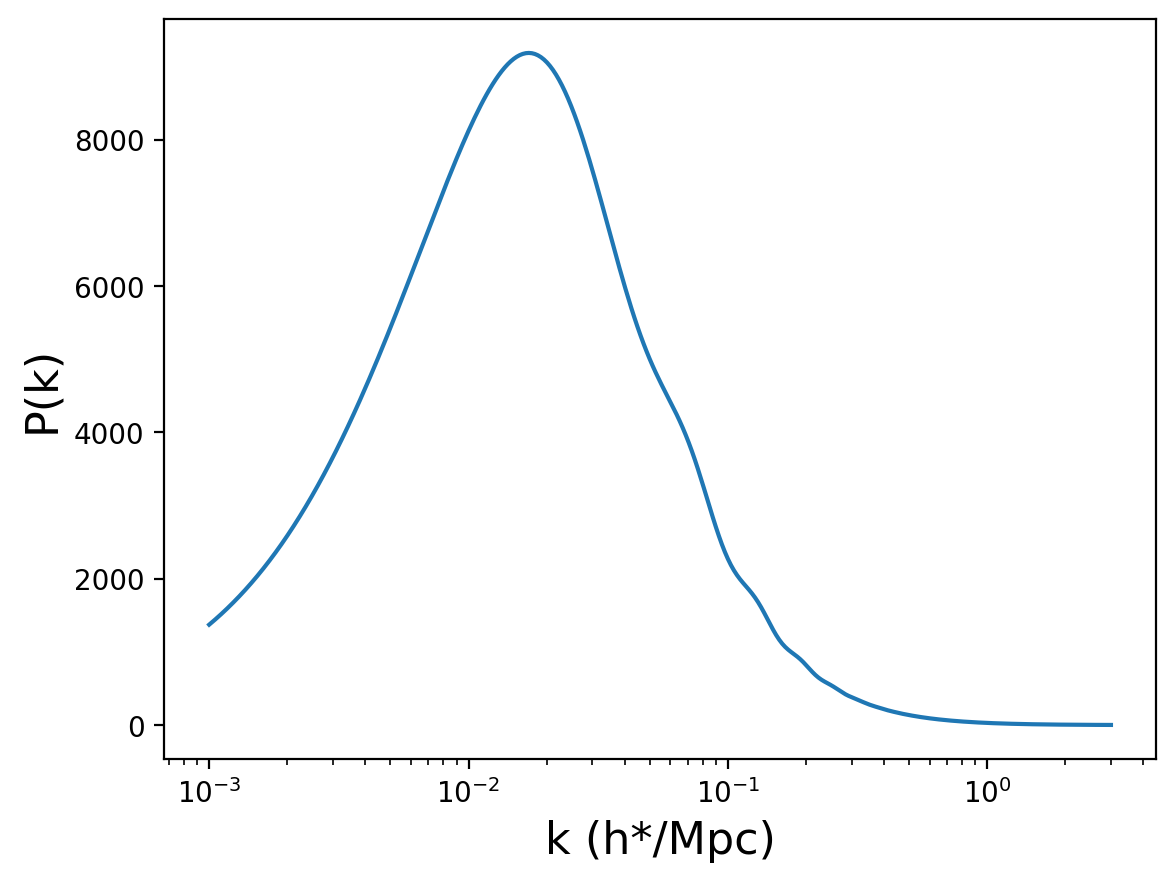

In [6]:
plt.xscale('log')
plt.plot(k_out_hfid, plin_cobra[0])
plt.xlabel('k (h*/Mpc)',fontsize=16)
plt.ylabel('P(k)',fontsize=16)
plt.show()

For more extended comparisons to CAMB at the linear level, see the benchmark notebook.

### Bayesian Analysis with COBRA 

If you want to run a Bayesian analysis using COBRA, it's as simple as putting the 'compute' call in your likelihood. The only important thing to remember is that you should create the COBRA instance outside of the likelihood - creating the instance is slow, since all the requisite tables need to be loaded into memory. Here is an example of COBRA to perform cosmological inference on the one-loop matter power spectrum in LCDM.

I use dynesty (https://arxiv.org/abs/1904.02180) for posterior sampling and getdist (https://arxiv.org/abs/1910.13970) for post-processing, but neither of these are requirements for COBRA.

In [7]:
import dynesty
import getdist
from getdist import plots, MCSamples
import time

Suppose we have measured the power spectrum in a box with 2 Gpc/h sides, and in some wavenumbers k in units of h/Mpc (where h is unknown to us). 

In [8]:
cosmo_1loop = {'omch2':[0.11], 'ombh2':[0.022], 'ns':[0.95], 'As': [2.3], 'h': [0.69], 'z':[0.5]} 

boxlen = 2000 # box side length in units of Mpc/h_true 
kf = 2 * np.pi / boxlen
dk = 0.005 ## some arbitrary choice of binning
h_true = cosmo_1loop['h'][0]
k_bins_h_true = np.arange(0.005, 0.25, dk) # k range in units of h_true / Mpc

n_mode = 4 * np.pi * dk * k_bins_h_true ** 2 / kf ** 3
frac_error = np.sqrt(2 / n_mode) ## fractional error on power spectrum in the Gaussian approximation
 
ctr = {'csq':[5]} # speed of sound counterterm, arbitrarily chosen

What is the true one-loop matter power spectrum at this cosmology and at these wavenumbers? For this, we need to convert the units back to h_fid / Mpc again:

In [9]:
# Convert to the units used in cobra.
k_bins_hfid_loop = k_bins_h_true * h_true / 0.7 

cobra_lcdm_ext = CobraLCDM(param_range = 'ext') # use the extended parameter range for illustration

## true vector in h_fid units 
data_vec_hfid = cobra_lcdm_ext.oneloop_matter_power(cosmo_1loop, ctr, k_bins_hfid_loop, 
                                               n_basis_list = [12,12], resum = True)[0] 
## true vector in h_true units
data_vec = data_vec_hfid * (h_true / 0.7) ** 3 

Set up the prior transform and log-likelihood used to fit the data:

In [10]:
bounds = np.array([[0.08, 0, 0.5, -100], [0.175, 5, 0.9, 100]]) # w_cdm, A_s, h + last entry is the counterterm

def ptform(u):
    return bounds[0] + (bounds[1] - bounds[0]) * u

def loglike(cosmo_and_ctr):
    omch2, As, h, csq = cosmo_and_ctr
    cosmo = {'omch2':[omch2], 'ombh2':[0.022], 'ns':[0.95], 'As':[As], 'h':[h],'z':[0.5]} # fix baryon density, spectral index and redshift
    k_bins_hfid_loop = k_bins_h_true * h / 0.7
    ctr = {'csq':[csq]}
    pred = cobra_lcdm_ext.oneloop_matter_power(cosmo, ctr, k_bins_hfid_loop, n_basis_list = [12,12], resum = True)[0] * (h / 0.7) ** 3
    return -0.5 * np.sum(((pred - data_vec) / (data_vec * frac_error)) ** 2)


Run the sampler (if you want to reproduce this, it should take < 1 min or so on a personal laptop).

In [11]:
start = time.time()

ndim = 4
sampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim, nlive=500, sample='unif')
sampler.run_nested(dlogz_init=0.0001, maxcall=10**6, print_progress=False) 
res1loop=sampler.results

end = time.time()
print(end-start)

43.8094699382782


And finally plot (cosmological) posteriors using getdist:

Removed no burn in


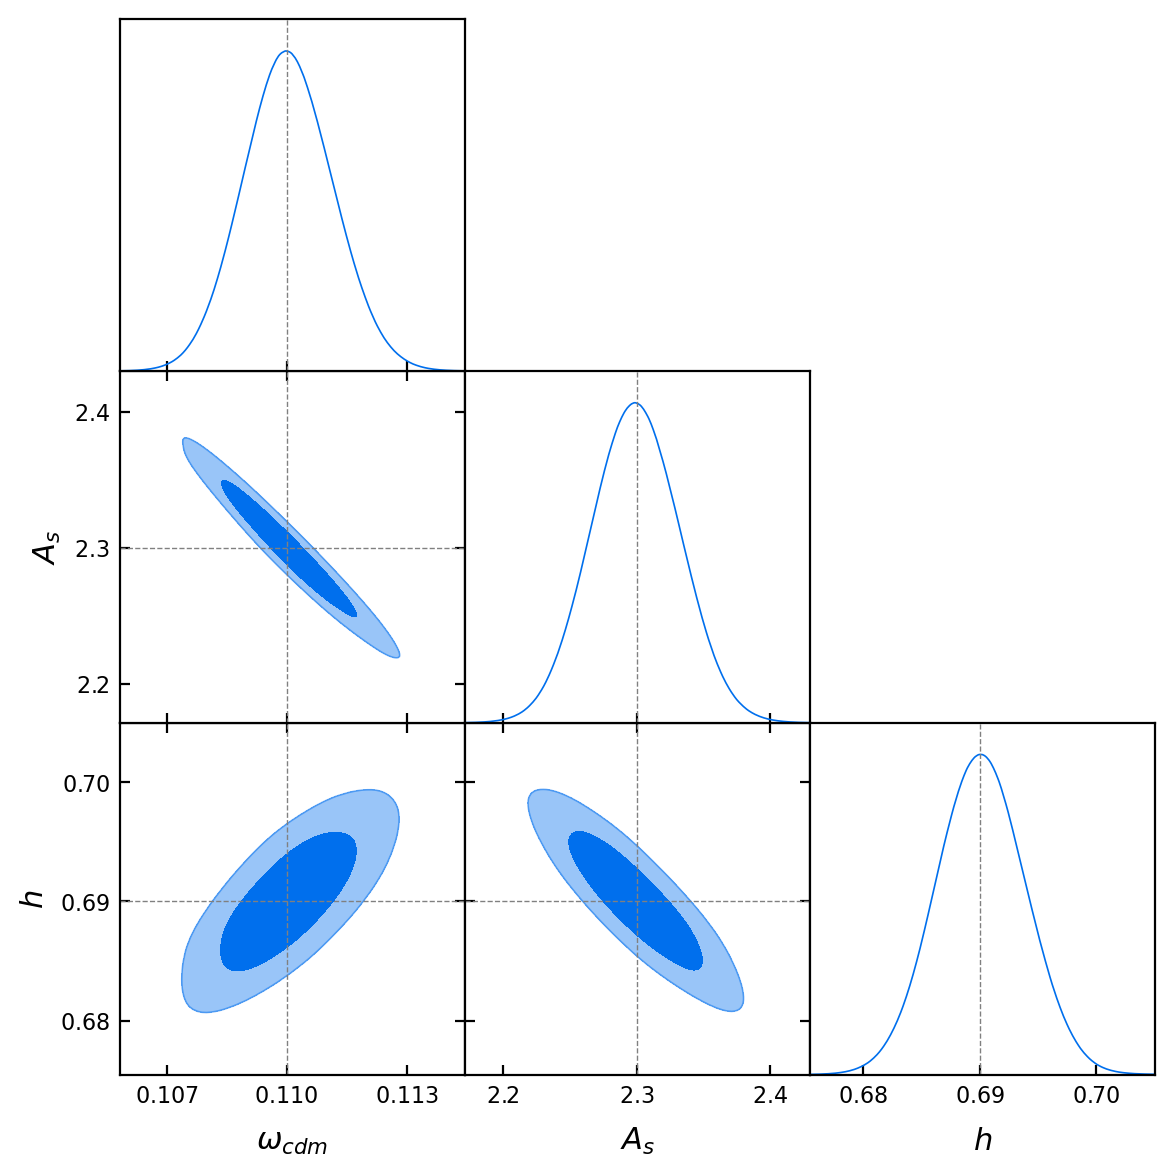

In [12]:
samps1loop = res1loop.samples
names = ["x%s"%i for i in range(ndim)]
labels =  [r'\omega_{cdm}',r'A_s','h']
getdist_mcsamps = MCSamples(samples = samps1loop, names = names, labels = labels, weights = np.exp(res1loop.logwt-np.max(res1loop.logwt)))

g = plots.get_subplot_plotter()
g.triangle_plot([getdist_mcsamps], ['x0', 'x1', 'x2'], 
                filled=True, markers = {'x0':0.11,'x1':2.3,'x2':0.69})   # Success!  